False
True


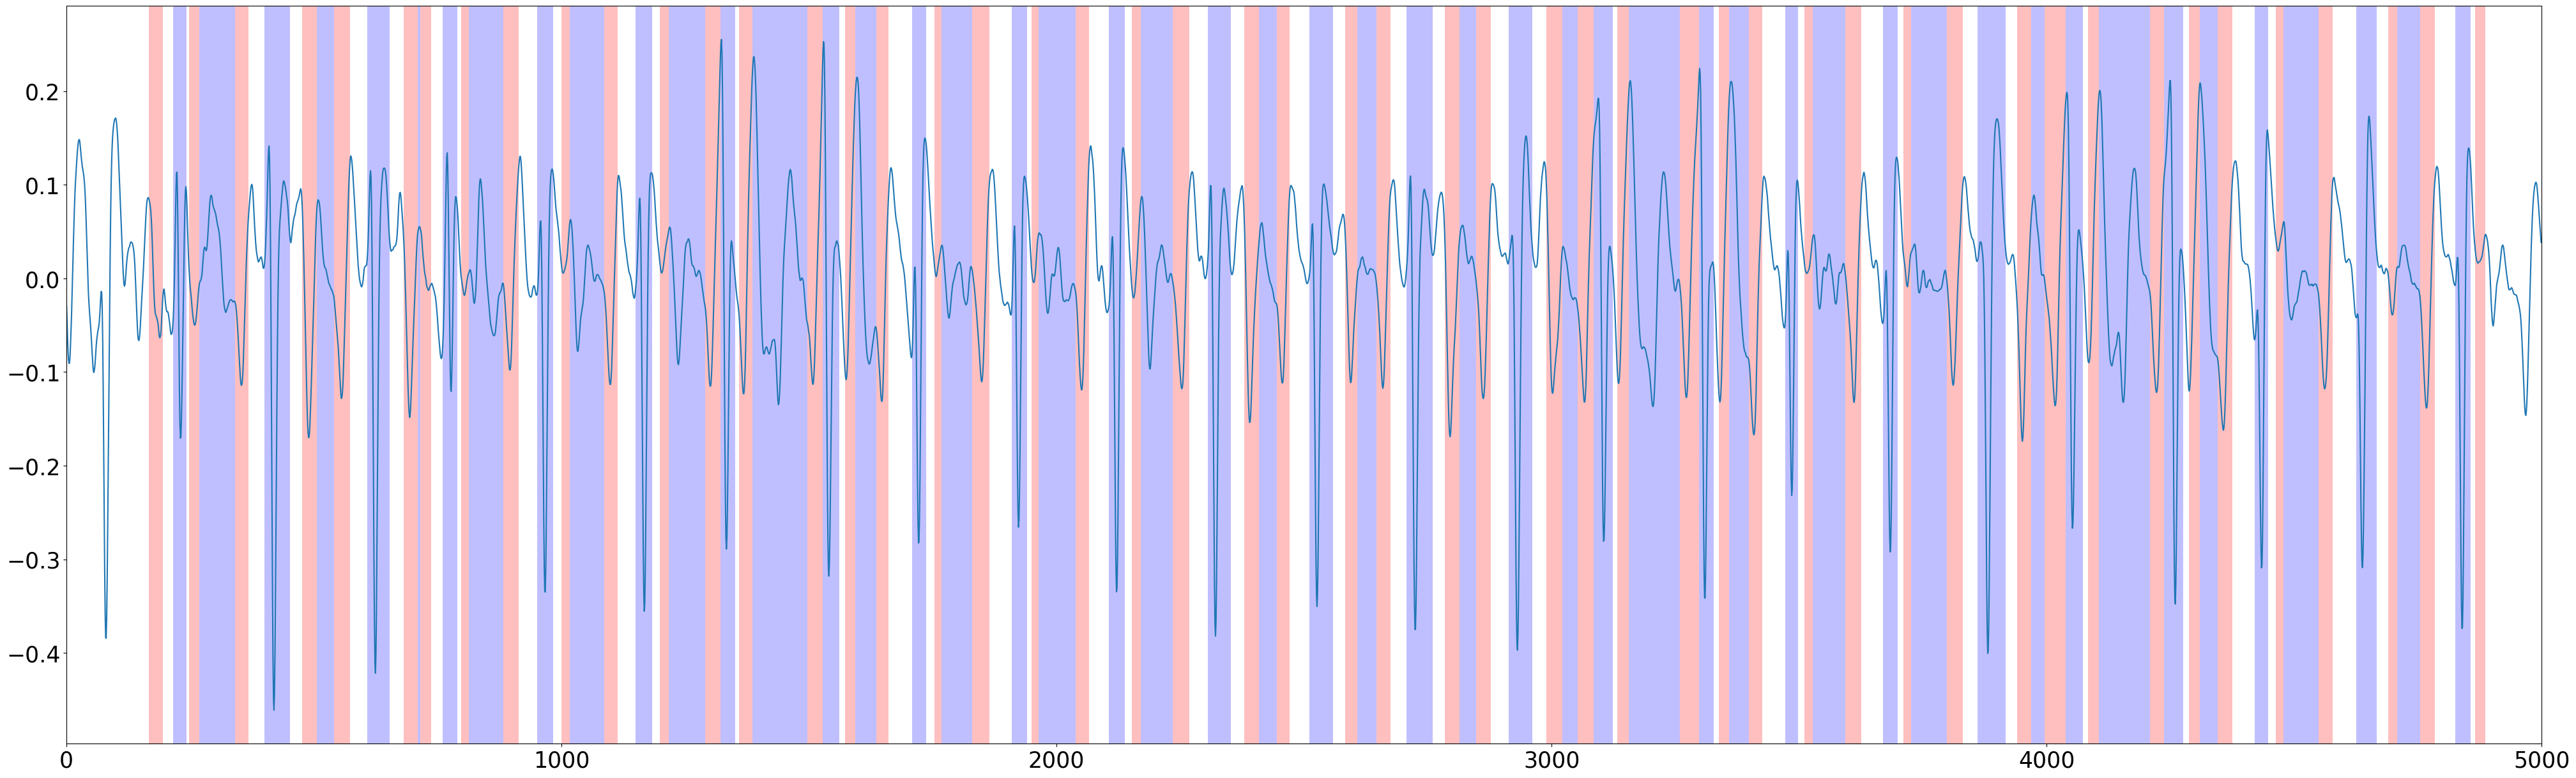

In [8]:
# ~~~~~~~~~~~~~~~ IMPORTS ~~~~~~~~~~~~~~~
from collections import Counter
import numpy as np
import os
import zipfile
import json
from pandas import *
import matplotlib.pyplot as plt
from biosppy.signals import ecg
import neurokit2 as nk
from scipy import signal

# ~~~~~~~~~~~~~~~ DATA FETCH ~~~~~~~~~~~~~~~
dir_path = '../../../../../../local1/CSE_XAI/small_data/'

# get 1 file
# count = 0
# # Iterate directory
# for path in os.listdir(dir_path):
#     patient_X = np.empty((2, 5000))

#     jsonFile = open(dir_path + path, 'r')
#     fileContents = json.load(jsonFile)

#     # digging into the dictionaries to get lead data
#     lead_1_samples = fileContents['samples']
#     lead_2_samples = fileContents['extraLeads'][0]['samples']

#     # Crop the data to 5000 data points (5 seconds).
#     patient_X[0,:] = lead_1_samples[0:5000]
#     patient_X[1,:] = lead_2_samples[0:5000]
#     count += 1
#     if count == 3: # just get 1.
#         break

patient_X = np.empty((2, 5000))

jsonFile = open(dir_path + "1a01rausczag4unrsujivsxzm_raw.json", 'r')

fileContents = json.load(jsonFile)

# digging into the dictionaries to get lead data
lead_1_samples = fileContents['samples']
lead_2_samples = fileContents['extraLeads'][0]['samples']
# Crop the data to 5000 data points (5 seconds).
patient_X[0,:] = lead_1_samples[0:5000]
patient_X[1,:] = lead_2_samples[0:5000]

'''
After getting a file, put it into a numpy array
Be able use the bio spy python library to get wave components from that numpy array
Output a list of wave component values with timestamp

'''
features = {"R": [], "P":[], "T":[], "TP":[]}
frequency = fileContents["frequency"]
duration = len(patient_X[0])

# smooth and straighten leads for inversion detection
filtered_lead_1 = ecg.ecg(patient_X[0], sampling_rate=frequency, show=False)[1]
filtered_lead_2 = ecg.ecg(patient_X[1], sampling_rate=frequency, show=False)[1]

# check if leads are inverted
inverted_lead_1 = nk.ecg_invert(filtered_lead_1, sampling_rate=frequency, show=False)[1]
inverted_lead_2 = nk.ecg_invert(filtered_lead_2, sampling_rate=frequency, show=False)[1]

print(inverted_lead_1)
print(inverted_lead_2)

if inverted_lead_1:
    # extract r-wave peak timestamps from inverted lead I (the inversion of the originally inverted lead)
    r_peaks_lead_1 = nk.ecg_peaks(np.negative(patient_X[0]), sampling_rate=frequency, method="neurokit", correct_artifacts=True)[1]["ECG_R_Peaks"]
    # correct r-wave peak timestamps to fit inverted lead I (the inversion of the originally inverted lead)
    r_peaks_lead_1 = ecg.correct_rpeaks(np.negative(patient_X[0]), r_peaks_lead_1, sampling_rate=frequency)[0]
else:
    # extract r-wave peak timestamps from lead I
    r_peaks_lead_1 = nk.ecg_peaks(patient_X[0], sampling_rate=frequency, method="neurokit", correct_artifacts=True)[1]["ECG_R_Peaks"]
    # correct r-wave peak timestamps
    r_peaks_lead_1 = ecg.correct_rpeaks(patient_X[0], r_peaks_lead_1, sampling_rate=frequency)[0]
if inverted_lead_2:
    # correct r-wave peak timestamps to fit inverted lead II (the inversion of the originally inverted lead)
    r_peaks_lead_2 = ecg.correct_rpeaks(np.negative(patient_X[1]), r_peaks_lead_1, sampling_rate=frequency)[0]
else:
    # correct r-wave peak timestamps to fit lead II
    r_peaks_lead_2 = ecg.correct_rpeaks(patient_X[1], r_peaks_lead_1, sampling_rate=frequency)[0]
if inverted_lead_2:
    # correct r-wave peak timestamps to fit inverted lead II (the inversion of the originally inverted lead)
    r_peaks_lead_2 = ecg.correct_rpeaks(np.negative(patient_X[1]), r_peaks_lead_1, sampling_rate=frequency)[0]
else:
    # correct r-wave peak timestamps to fit lead II
    r_peaks_lead_2 = ecg.correct_rpeaks(patient_X[1], r_peaks_lead_1, sampling_rate=frequency)[0]

features["R"] = r_peaks_lead_1

# filter out baseline wander in lead II
filtered_lead_2 = nk.signal_filter(patient_X[1], sampling_rate=frequency, lowcut=3, highcut=None, method="butterworth", order=2, show=False)

# filter out powerline interference in lead II
filtered_lead_3 = nk.signal_filter(filtered_lead_2, sampling_rate=frequency, lowcut=None, highcut=None, method="powerline", powerline=50, show=False)

# filter out EMG noise in lead II

# filter out electrode motion artifacts in lead II

# extract p_positions-wave peak timestamps from filtered lead II
if inverted_lead_2:
    peaks_lead_2 = nk.ecg_delineate(np.negative(filtered_lead_3), r_peaks_lead_2, sampling_rate=frequency, method="dwt", show=False, check=False)[0]
else:
    peaks_lead_2 = nk.ecg_delineate(filtered_lead_3, r_peaks_lead_2, sampling_rate=frequency, method="dwt", show=False, check=False)[0]

p_starts_lead_2 = []
p_ends_lead_2 = []

for i, v in enumerate(peaks_lead_2["ECG_P_Onsets"]):
    if v == 1:
        p_starts_lead_2.append(i)

for i, v in enumerate(peaks_lead_2["ECG_P_Offsets"]):
    if v == 1:
        p_ends_lead_2.append(i)

if (p_starts_lead_2[0] > p_ends_lead_2[0]) and ((p_starts_lead_2[len(p_starts_lead_2) // 2] > p_ends_lead_2[len(p_starts_lead_2) // 2]) or (p_starts_lead_2[-2] > p_ends_lead_2[-2])):
    p_positions = list(zip(p_starts_lead_2, p_ends_lead_2[1:]))
else:
    p_positions = list(zip(p_starts_lead_2, p_ends_lead_2))

q_starts_lead_2 = []
s_ends_lead_2 = []

for i, v in enumerate(peaks_lead_2["ECG_R_Onsets"]):
    if v == 1:
        q_starts_lead_2.append(i)

for i, v in enumerate(peaks_lead_2["ECG_R_Offsets"]):
    if v == 1:
        s_ends_lead_2.append(i)

try:
    # Fix overlapping for PR and QRS
    for i in range(2, len(q_starts_lead_2)):
        if q_starts_lead_2[i] - q_starts_lead_2[i - 1] > (q_starts_lead_2[i - 1] - q_starts_lead_2[i - 2]) * 1.5:
            if (q_starts_lead_2[0] < s_ends_lead_2[0]) and ((q_starts_lead_2[len(q_starts_lead_2) // 2] < s_ends_lead_2[len(q_starts_lead_2) // 2]) or (q_starts_lead_2[-2] < s_ends_lead_2[-2])):
                q_starts_lead_2.insert(i, s_ends_lead_2[i - 1] - (s_ends_lead_2[i - 1] - q_starts_lead_2[i - 1]))
            else:
                q_starts_lead_2.insert(i, s_ends_lead_2[i + 1] - (s_ends_lead_2[i] - q_starts_lead_2[i - 1]))

    for i in range(2, len(s_ends_lead_2)):
        if s_ends_lead_2[i] - s_ends_lead_2[i - 1] > (s_ends_lead_2[i - 1] - s_ends_lead_2[i - 2]) * 1.5:
            if (q_starts_lead_2[0] < s_ends_lead_2[0]) and ((q_starts_lead_2[len(q_starts_lead_2) // 2] < s_ends_lead_2[len(q_starts_lead_2) // 2]) or (q_starts_lead_2[-2] < s_ends_lead_2[-2])):
                s_ends_lead_2.insert(i, q_starts_lead_2[i] + (s_ends_lead_2[i - 1] - q_starts_lead_2[i - 1]))
            else:
                s_ends_lead_2.insert(i, q_starts_lead_2[i - 1] + (s_ends_lead_2[i - 1] - q_starts_lead_2[i - 2]))

    for i in range(len(q_starts_lead_2)):
        if (q_starts_lead_2[0] < p_ends_lead_2[0]) and ((q_starts_lead_2[len(q_starts_lead_2) // 2] < p_ends_lead_2[len(q_starts_lead_2) // 2]) or (q_starts_lead_2[-2] < p_ends_lead_2[-2])):
            if q_starts_lead_2[i + 1] < p_ends_lead_2[i]:
                q_starts_lead_2[i + 1] = p_ends_lead_2[i] 
        else:
            if q_starts_lead_2[i] < p_ends_lead_2[i]:
                q_starts_lead_2[i] = p_ends_lead_2[i]

    if (q_starts_lead_2[0] < p_ends_lead_2[0]) and ((q_starts_lead_2[len(q_starts_lead_2) // 2] < p_ends_lead_2[len(q_starts_lead_2) // 2]) or (q_starts_lead_2[-2] < p_ends_lead_2[-2])):
        pr_positions = list(zip(p_ends_lead_2, q_starts_lead_2[1:]))
    else:
        pr_positions = list(zip(p_ends_lead_2, q_starts_lead_2))
except:
    print("Bad ECG :(")

t_starts_lead_2 = []
t_ends_lead_2 = []

for i, v in enumerate(peaks_lead_2["ECG_T_Onsets"]):
    if v == 1:
        t_starts_lead_2.append(i)

for i, v in enumerate(peaks_lead_2["ECG_T_Offsets"]):
    if v == 1:
        t_ends_lead_2.append(i)

try:
    QRS_positions = []
    for i in range(len(q_starts_lead_2)):
        if (q_starts_lead_2[0] > s_ends_lead_2[0]) and ((q_starts_lead_2[len(q_starts_lead_2) // 2] > s_ends_lead_2[len(q_starts_lead_2) // 2]) or (q_starts_lead_2[-2] > s_ends_lead_2[-2])):
            QRS_positions.append([q_starts_lead_2[i], min(s_ends_lead_2[i + 1], t_starts_lead_2[i + 1])])
        else:
            QRS_positions.append([q_starts_lead_2[i], min(s_ends_lead_2[i], t_starts_lead_2[i])])

    if (t_starts_lead_2[0] < s_ends_lead_2[0]) and ((t_starts_lead_2[len(t_starts_lead_2) // 2] < s_ends_lead_2[len(t_starts_lead_2) // 2]) or (t_starts_lead_2[-2] < s_ends_lead_2[-2])):
        ST_positions = list(zip(s_ends_lead_2, t_starts_lead_2[1:]))
    else:
        ST_positions = list(zip(s_ends_lead_2, t_starts_lead_2))

    # Fix overlapping for ST
    for i in range(len(s_ends_lead_2)):
        if (t_starts_lead_2[0] < s_ends_lead_2[0]) and ((t_starts_lead_2[len(t_starts_lead_2) // 2] < s_ends_lead_2[len(t_starts_lead_2) // 2]) or (t_starts_lead_2[-2] < s_ends_lead_2[-2])):
            if t_starts_lead_2[i] < s_ends_lead_2[i + 1]:
                t_starts_lead_2[i] = s_ends_lead_2[i + 1] 
        else:
            if t_starts_lead_2[i] < s_ends_lead_2[i]:
                t_starts_lead_2[i] = s_ends_lead_2[i]
except:
    print("Bad ECG :(")
    if (p_ends_lead_2[0] > t_starts_lead_2[0]) and ((p_ends_lead_2[len(p_ends_lead_2) // 2] > t_starts_lead_2[len(p_ends_lead_2) // 2]) or (p_ends_lead_2[-2] > t_starts_lead_2[-2])):
        QRS_positions = list(zip(p_ends_lead_2, t_starts_lead_2[1:]))
    else:
        QRS_positions = list(zip(p_ends_lead_2, t_starts_lead_2))

if (t_starts_lead_2[0] > t_ends_lead_2[0]) and ((t_starts_lead_2[len(t_starts_lead_2) // 2] > t_ends_lead_2[len(t_starts_lead_2) // 2]) or (t_starts_lead_2[-2] > t_ends_lead_2[-2])):
    t_positions = list(zip(t_starts_lead_2, t_ends_lead_2[1:]))
else:
    t_positions = list(zip(t_starts_lead_2, t_ends_lead_2))

if (t_ends_lead_2[0] > p_starts_lead_2[0]) and ((t_ends_lead_2[len(t_ends_lead_2) // 2] > p_starts_lead_2[len(t_ends_lead_2) // 2]) or (t_ends_lead_2[-2] > p_starts_lead_2[-2])):
    tp_positions = list(zip(t_ends_lead_2, p_starts_lead_2[1:]))
else:
    tp_positions = list(zip(t_ends_lead_2, p_starts_lead_2))

for i in p_positions:
    plt.axvspan(i[0], i[1], facecolor="r", alpha=0.25)

# for i in pr_positions:
#     plt.axvspan(i[0], i[1], facecolor="b", alpha=0.25)

for i in QRS_positions:
    plt.axvspan(i[0], i[1], facecolor="b", alpha=0.25)

# for i in ST_positions:
#     plt.axvspan(i[0], i[1], facecolor="b", alpha=0.25)

for i in t_positions:
    plt.axvspan(i[0], i[1], facecolor="r", alpha=0.25)

for i in tp_positions:
    plt.axvspan(i[0], i[1], facecolor="b", alpha=0.25)

plt.rcParams["figure.figsize"] = (50, 15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.plot(patient_X[1])
plt.plot(filtered_lead_3)
# for i in r_peaks_lead_2:
#     plt.axvline(i, color="r")
plt.xlim(0, 5000)
plt.show()